In [1]:
qpath = r'../../quetzal/' # path to quetzal here
import sys
sys.path.insert(0, qpath)

data = r'inputs/'

# import class
from quetzal.io.gtfs_reader import importer

### Read GTFS

In [2]:
feed = importer.GtfsImporter(path=data + r'accra_trotro', dist_units='m')
feed = feed.clean()
feed.describe()

,indicator,value
0,agencies,[AMA Department of Transport]
1,running_services,[0]
2,timezone,Africa/Accra
3,start_date,20190304
4,end_date,20200131
5,num_routes,277
6,num_trips,554
7,num_stops,4171
8,num_shapes,554
9,num_frequencies,554


In [3]:
feed.map_stops(
    feed.stops.stop_id
)

To simplify a GTFS or for modeling purposes, we often want to group trips that are not geographically identical, but close to each other.  
The default method to build patterns only group geographically identical trips. It however possible to clusterize the station in order to broaden the definition of a pattern.

####  Stop clustering

This method allows to clusterize the stops based on a distance threshold (and not a number of cluster threshold).
It is however not efficient for large feeds.  

Tested and working up to 5000 stops until now.

In [4]:
feed.build_stop_clusters(
    distance_threshold=300  # It is also possible to use the parent stations
) 

This adds a cluster_id column to the stops

In [5]:
feed.stops.head()

,stop_name,stop_id,location_type,parent_station,cluster_id,stop_lon,stop_lat
0,Tse Addo,5010786347,0,SA5010786347,1081,-0.138535,5.587618
1,Bostal,5030747563,0,SA5030747563,358,-0.188797,5.606415
2,Second Juction,5010786348,0,SA5010786348,60,-0.141622,5.585648
3,Junction,5010786349,0,SA5010786349,60,-0.142669,5.584328
4,Fadama,SA4990070170,1,NaN,732,-0.240793,5.601748


In [6]:
print('N stops:', len(feed.stops))
print('N clusters:', len(feed.stops.cluster_id.unique()))

N stops: 4171
N clusters: 1095


Map some stops and clusters

In [7]:
from shapely.geometry import LineString
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)

c:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_latest\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot: >

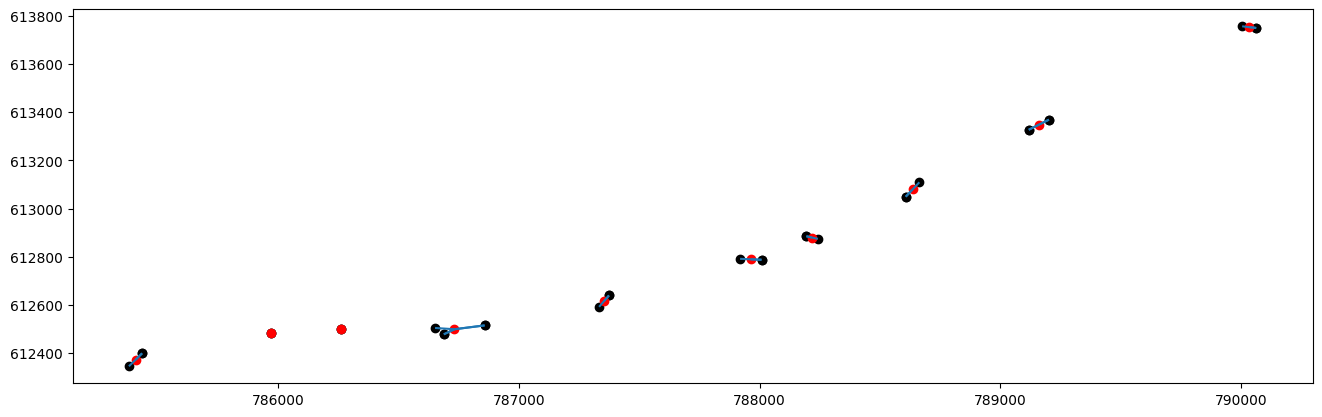

In [8]:
stops = feed.geometrize_stops(use_utm=True)
# Selection of close clusters and associated stops
c = feed.stops.sort_values(['stop_lon', 'stop_lat']).head(30)['cluster_id'].unique()
stops_to_plot = stops[stops['cluster_id'].isin(c)]
# GDF to plot
clusters = stops_to_plot.dissolve('cluster_id')
clusters.geometry = clusters.geometry.centroid
s_c = stops_to_plot.copy()
s_c.geometry = s_c.apply(
    lambda x: LineString(
        [x.geometry, clusters.loc[x['cluster_id'], 'geometry']]
    ),
    1
)
# Plot
s_c.plot(
    ax=clusters.plot(
        color='r', ax=stops_to_plot.plot(
            color='k'
        )
    )
)

#### Patterns

Patterns definition can be based on the cluster_id columns instead of the stop_id.

In [9]:
feed.build_patterns(on='cluster_id')

#### Directions

It can also be used to derive the directions of the trips if they are not known

In [10]:
feed.build_directions(
    on='cluster_id',
    all_trips=True  # With all_trips=False, we only compute undefined directions
)

c:\Users\rgoix\Documents\dev\formation\syspy_examples\gtfs_reader\../../quetzal\quetzal\io\gtfs_reader\directions.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feed.trips.drop('direction_id', 1, inplace=True)


In [11]:
feed.trips.head()

,route_id,trip_id,service_id,shape_id,trip_headsign,pattern_id,direction_id
0,7589525,344,0,7589522,Nima Overhead Maamobi,7589525_0,1
1,7437148,0,0,7437119,Amasaman,7437148_0,1
2,7435747,346,0,7435456,Ashaiman Main Station,7435747_0,0
3,7435747,347,0,7435650,Abeka Lapaz,7435747_1,1
4,7476946,340,0,7476945,Nima,7476946_0,0
